<a href="https://colab.research.google.com/github/RaghavDM1976/IK_Python/blob/main/Introduction_To_Agents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction to Agents


This notebook is designed to introduce the concept of "agents" in the context of LangChain, a framework for developing applications powered by language models. It walks you through setting up the necessary environment and building a simple agent that can use tools to perform tasks.

# 1. Installation & Setup

## Setup and Installation

The first step is to install the necessary Python libraries. We will use `pip` to install the following packages:

* `langchainhub`: To access pre-built agent prompts and chains from the LangChain hub.
* `langchain-openai`: This library provides the interface to connect with OpenAI's language models, which will be the "brain" of our agent.
* `faiss-cpu`: A library for efficient similarity search and clustering of dense vectors. It's often used for agents that need to perform a vector search.
* `tavily-python`: This library provides a powerful search tool that the agent can use to find information from the web.

In [1]:
%%time

# 🧹 Full clean install for LangChain (modern modular ecosystem)
!pip uninstall -y langchain langchain-core langchain-community langchain-openai langchainhub faiss-cpu > /dev/null
!pip install -q --upgrade pip setuptools wheel

# Install in sequence to avoid ResolutionImpossible
!pip install -q langchain-core==0.3.15
!pip install -q langchain==0.3.15
!pip install -q langchain-community==0.3.15
!pip install -q langchain-openai==0.2.11
!pip install -q langchainhub==0.1.15
!pip install -q faiss-cpu==1.8.0.post1
!pip install -q beautifulsoup4 jedi==0.19.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 68.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-text-splitters 0.3.11 requires langchain-core<2.0.0,>=0.3.75, but you have langchain-core 0.3.15 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.7

In [ ]:
import os
os.kill(os.getpid(), 9)  # ♻️ clean restart


In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI
from langchain.chains.retrieval import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.vectorstores import FAISS
import os

# prompt = ChatPromptTemplate.from_template("Translate this to French: {text}")
# llm = ChatOpenAI(model="gpt-4o-mini")
# parser = StrOutputParser()
# chain = prompt | llm | parser
# print(chain.invoke({"text": "Hello, my friend!"}))

print("✅ LangChain modern API working perfectly!")


✅ LangChain modern API working perfectly!


# 2. API Key Setup
Enter API keys required for authenticating with OpenAI and Tavily service



In [3]:
from google.colab import userdata
#OPENAI_API_KEY = userdata.get('OPEN_AI_KEY_NEW')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
print(f"OPENAI_API_KEY: {OPENAI_API_KEY[:7]} .....")
TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
print(f"TAVILY_API_KEY: {TAVILY_API_KEY[:7]} .....")
LANGCHAIN_API_KEY = userdata.get('LANGCHAIN_API_KEY')
print(f"LANGCHAIN_API_KEY: {LANGCHAIN_API_KEY[:7]} .....")

OPENAI_API_KEY: sk-proj .....
TAVILY_API_KEY: tvly-de .....
LANGCHAIN_API_KEY: lsv2_pt .....


In [4]:
import os
os.environ['USER_AGENT'] = 'YourCustomUserAgent'

from langchain_community.document_loaders import WebBaseLoader

In [5]:
# Prompt the user to enter their OpenAI API key securely

# os.environ["OPENAI_API_KEY"] = getpass.getpass()
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [6]:
# Prompt for Tavily API key (for search tool)

# os.environ["TAVILY_API_KEY"] = getpass.getpass()
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY

# 3. Document Loading & Vector Store

Here, we load documentation from Langchain and process it so the agent can reference accurate information.

In [7]:
# LangChain Imports: Imports LangChain components to build agents and tools.

from langchain_community.document_loaders import WebBaseLoader
loader = WebBaseLoader([
    "https://docs.smith.langchain.com/",
    "https://docs.langchain.com/langsmith/observability-quickstart",
    "https://docs.langchain.com/langsmith/evaluation-quickstart",
    "https://docs.langchain.com/langsmith/prompt-engineering-quickstart",
    "https://docs.langchain.com/langsmith/administration-overview"
    ])

docs = loader.load()

# 4. Embeddings & Indexing

In [8]:
# Create embeddings using OpenAI models

from langchain_openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

In [9]:
# Split documents and store them in FAISS for efficient search

from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter


text_splitter = RecursiveCharacterTextSplitter(chunk_size=300)
documents = text_splitter.split_documents(docs)
vector = FAISS.from_documents(documents, embeddings)

In [11]:
vector.similarity_search("apple", k=1)

[Document(id='d6ec99ce-c939-4b17-aa9c-0fcb25bf4cb0', metadata={'source': 'https://docs.langchain.com/langsmith/evaluation-quickstart', 'title': 'Evaluation quickstart - Docs by LangChain', 'language': 'en'}, page_content='â€‹Video guide')]

In [12]:
# Display split documents for verification
print(documents)

[Document(metadata={'source': 'https://docs.smith.langchain.com/', 'title': 'LangSmith docs - Docs by LangChain', 'language': 'en'}, page_content="LangSmith docs - Docs by LangChainSkip to main contentðŸš€ Share how you're building agents for a chance to win LangChain swag!Docs by LangChain home pageLangSmithSearch...âŒ˜KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangSmith docsGet startedObservabilityEvaluationPrompt"), Document(metadata={'source': 'https://docs.smith.langchain.com/', 'title': 'LangSmith docs - Docs by LangChain', 'language': 'en'}, page_content='for a chance to win LangChain swag!Docs by LangChain home pageLangSmithSearch...âŒ˜KAsk AIGitHubTry LangSmithTry LangSmithSearch...NavigationLangSmith docsGet startedObservabilityEvaluationPrompt engineeringDeploymentAgent BuilderPlatform setupOverviewPlansCreate an account and API keyAccount'), Document(metadata={'source': 'https://docs.smith.langchain.com/', 'title': 'LangSmith docs - Docs by LangChain', 'langu

# 5. Build Document & Retrieval Chains
Define how prompts and questions are structured, and create chains for document retrieval and response generation.

In [13]:
# Create chain that feeds documents to an LLM with a specific prompt template

from langchain.chains.combine_documents import create_stuff_documents_chain
# create_stuff_documents_chain :
#  Create a chain for passing a list of Documents to a model.

llm = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"])
output_parser = StrOutputParser()

prompt = ChatPromptTemplate.from_template("""Answer the following question based only on the provided context:

<context>
{context}
</context>

Question: {input}""", output_parser = output_parser)

document_chain = create_stuff_documents_chain(llm, prompt) # prompt | llm

# 6. Retriever & Agent Construction
Set up tools for searching and create an OpenAI-powered agent that can answer questions or retrieve information.

In [15]:
# Initialize retriever and wrap in a retrieval chain
retriever = vector.as_retriever()
retrieval_chain = create_retrieval_chain(retriever, document_chain)

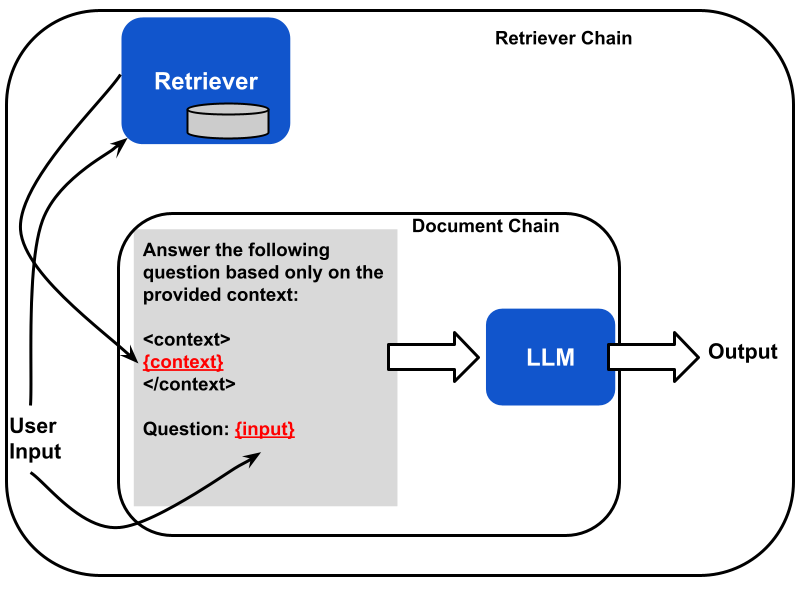

# 7. Tool Definitions
Define additional tools for tasks such as search, addition, multiplication, and exponentiation.

In [16]:
# Import and define custom tools using decorators
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "langsmith_search",
    "Search for information about LangSmith. For any questions about LangSmith, you must use this tool! Like What can I use langsmith for?",
)

In [18]:
from langchain_community.tools.tavily_search import TavilySearchResults

search = TavilySearchResults()

In [19]:
tools = [retriever_tool, search]

# 8. Agent Execution
Combine all tools and prompts to enable intelligent question-answering using OpenAI Functions Agent.

In [20]:
os.environ["LANGCHAIN_API_KEY"] = LANGCHAIN_API_KEY

In [21]:
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain.agents import create_openai_functions_agent
from langchain.agents import AgentExecutor

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent",
                  api_key=os.environ["LANGCHAIN_API_KEY"]
                  )

# You need to set OPENAI_API_KEY environment variable or pass it as argument `api_key`.
llm = ChatOpenAI(model="gpt-3.5-turbo", temperature=0)
agent = create_openai_functions_agent(llm, tools, prompt)
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

In [22]:
print(prompt)

input_variables=['agent_scratchpad', 'input'] optional_variables=['chat_history'] input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')]

In [23]:
print(prompt.input_variables)
print(prompt.messages)

['agent_scratchpad', 'input']
[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}), MessagesPlaceholder(variable_name='chat_history', optional=True), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}), MessagesPlaceholder(variable_name='agent_scratchpad')]


In [24]:
print(prompt.messages)

[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant'), additional_kwargs={}), MessagesPlaceholder(variable_name='chat_history', optional=True), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}'), additional_kwargs={}), MessagesPlaceholder(variable_name='agent_scratchpad')]


In [25]:
for msg in prompt.messages:
    print(msg)
    print("--------")

prompt=PromptTemplate(input_variables=[], input_types={}, partial_variables={}, template='You are a helpful assistant') additional_kwargs={}
--------
variable_name='chat_history' optional=True
--------
prompt=PromptTemplate(input_variables=['input'], input_types={}, partial_variables={}, template='{input}') additional_kwargs={}
--------
variable_name='agent_scratchpad'
--------


# 9. Example Usage & Outputs
Demonstrate how to ask questions to LangSmith or fetch general info (e.g., weather).

In [26]:
result = agent_executor.invoke({"input": "What can I use langsmith for?"})



> Entering new AgentExecutor chain...

Invoking: `langsmith_search` with `{'query': 'What can I use LangSmith for?'}`


It helps you trace requests, evaluate outputs, test prompts, and manage deployments in one place.
LangSmith is framework agnostic, so you can use it with or without LangChainâ€™s open-source libraries
langchain and langgraph.

For convenience, LangChain applications built with the LangSmith SDK has this capability built-in.

LangSmith is framework agnostic, so you can use it with or without LangChainâ€™s open-source libraries
langchain and langgraph.
Prototype locally, then move to production with integrated monitoring and evaluation to build more reliable AI systems.

out to LangSmith Support with details about your applications throughput needs and sample code and we can work with you to better understand whether the best approach is fixing a bug, changes to your application code, or a different LangSmith plan.LangSmith can be used for tracing requests, evaluating

In [27]:
print(result["output"])

LangSmith can be used for tracing requests, evaluating outputs, testing prompts, and managing deployments in one place. It is framework agnostic, so you can use it with or without LangChain's open-source libraries like langchain and langgraph. LangSmith allows you to prototype locally and then move to production with integrated monitoring and evaluation to build more reliable AI systems. If you have specific questions or need assistance with LangSmith, you can reach out to LangSmith Support with details about your application's throughput needs and sample code for further assistance.


In [28]:
result = agent_executor.invoke({"input": "what is the weather in SF?"})



> Entering new AgentExecutor chain...

Invoking: `tavily_search_results_json` with `{'query': 'weather in San Francisco'}`


[{'url': 'https://www.weather25.com/north-america/usa/california/san-francisco?page=month&month=November', 'content': 'rain possible 0 mm 15°/12°Saturday Nov 22 Image 18: Sunny 0 mm 15°/12°Sunday Nov 23 Image 19: Sunny 0 mm 14°/11°Monday Nov 24 Image 20: Sunny 0 mm 16°/12°Tuesday Nov 25 Image 21: Overcast 0 mm 16°/13°Next Month >> [...] | 23 Image 50: Sunny 14°/11° | 24 Image 51: Sunny 16°/12° | 25 Image 52: Overcast 16°/13° | 26 Image 53: Sunny 15°/10° | 27 Image 54: Sunny 16°/9° | 28 Image 55: Sunny 14°/9° | 29 Image 56: Sunny 14°/9° |\n| 30 Image 57: Partly cloudy 15°/9° |  |  |  |  |  |  | [...] | 9 Image 36: Sunny 16°/10° | 10 Image 37: Partly cloudy 17°/10° | 11 Image 38: Sunny 17°/10° | 12 Image 39: Overcast 16°/13° | 13 Image 40: Moderate rain 15°/14° | 14 Image 41: Partly cloudy 17°/13° | 15 Image 42: Partly cloudy 15°/12° |\n| 16 Image 43: Moderate ra

In [ ]:
print(result["output"])

The weather in San Francisco for the upcoming days is as follows:
- Nov. 9: Patchy rain possible, with a temperature of 16° / 9°
- Nov. 10: Overcast, with a temperature of 17° / 10°
- Nov. 11: Sunny, with a temperature of 17° / 10°
- Nov. 12: Overcast, with a temperature of 16° / 10°
- Nov. 13: Sunny, with a temperature of 16° / 9°
- Nov. 14: Overcast, with a temperature of 16° / 11°
- Nov. 15: Patchy rain possible, with a temperature of 20° / 11°
- Nov. 16: Heavy rain, with a temperature of 14° / 12°
- Nov. 17: Heavy rain, with a temperature of 13° / 12°
- Nov. 18: Sunny, with a temperature of 14° / 11°

You can expect cooler weather in the upcoming days with some rain showers.


In [29]:
result = agent_executor.invoke({"input": "how to do RecursiveCharacterTextSplitter"})



> Entering new AgentExecutor chain...

Invoking: `langsmith_search` with `{'query': 'RecursiveCharacterTextSplitter'}`


to modelsTutorialsOptimize a classifierSync prompts with GitHubTest multi-turn conversationsOn this pagePrerequisitesNext stepsVideo guidePrompt engineering quickstartCopy pageCopy pagePrompts guide the behavior of large language models (LLM). Prompt engineering is the process of crafting, testing,

LangSmith lets you set two different monthly limits, mirroring our Billable Metrics discussed in the aforementioned data retention guide:

For convenience, LangChain applications built with the LangSmith SDK has this capability built-in.

is a critical requirement for applications built with large language models (LLMs). LLMs are non-deterministic, which means that the same prompt can produce different responses. This behavior makes debugging and monitoring more challenging than with traditional software.The search results did not provide specific information about Recu

In [30]:
result = agent_executor.invoke({"input": "What is my name?"})



> Entering new AgentExecutor chain...
I'm sorry, but I don't have access to your personal information. If there's anything else I can help you with, feel free to let me know!

> Finished chain.


# 10. Custom Arithmetic Tools

In [31]:
from langchain_core.tools import tool

Sample implementations of addition, multiplication, and exponentiation as callable agent tools.

In [32]:
## Add two more tools that perform addition and exponentiation
@tool
def multiply(first_int: int, second_int: int) -> int:
    """Multiply two integers together."""
    return first_int * second_int

@tool
def add(first_int: int, second_int: int) -> int:
    "Add two integers."
    return first_int + second_int


@tool
def exponentiate(base: int, exponent: int) -> int:
    "Exponentiate the base to the exponent power."
    return base**exponent

In [33]:
print(multiply.name)
print(multiply.description)
print(multiply.args)

multiply
Multiply two integers together.
{'first_int': {'title': 'First Int', 'type': 'integer'}, 'second_int': {'title': 'Second Int', 'type': 'integer'}}


In [34]:
multiply.invoke({"first_int": 4, "second_int": 5})

20

In [35]:
from langchain.tools.render import render_text_description

rendered_tools = render_text_description([multiply])
print(rendered_tools)

multiply(first_int: int, second_int: int) -> int - Multiply two integers together.
